## Component Generation Pipeline Implementation 1

This is quick reference implementation of generating components in a pipeline.

1. List services
2. Expand each service to an Open-Control files
3. Expand each Open-Control file to an OSCAL file
4. Push each OSCAL file into GovReady-Q

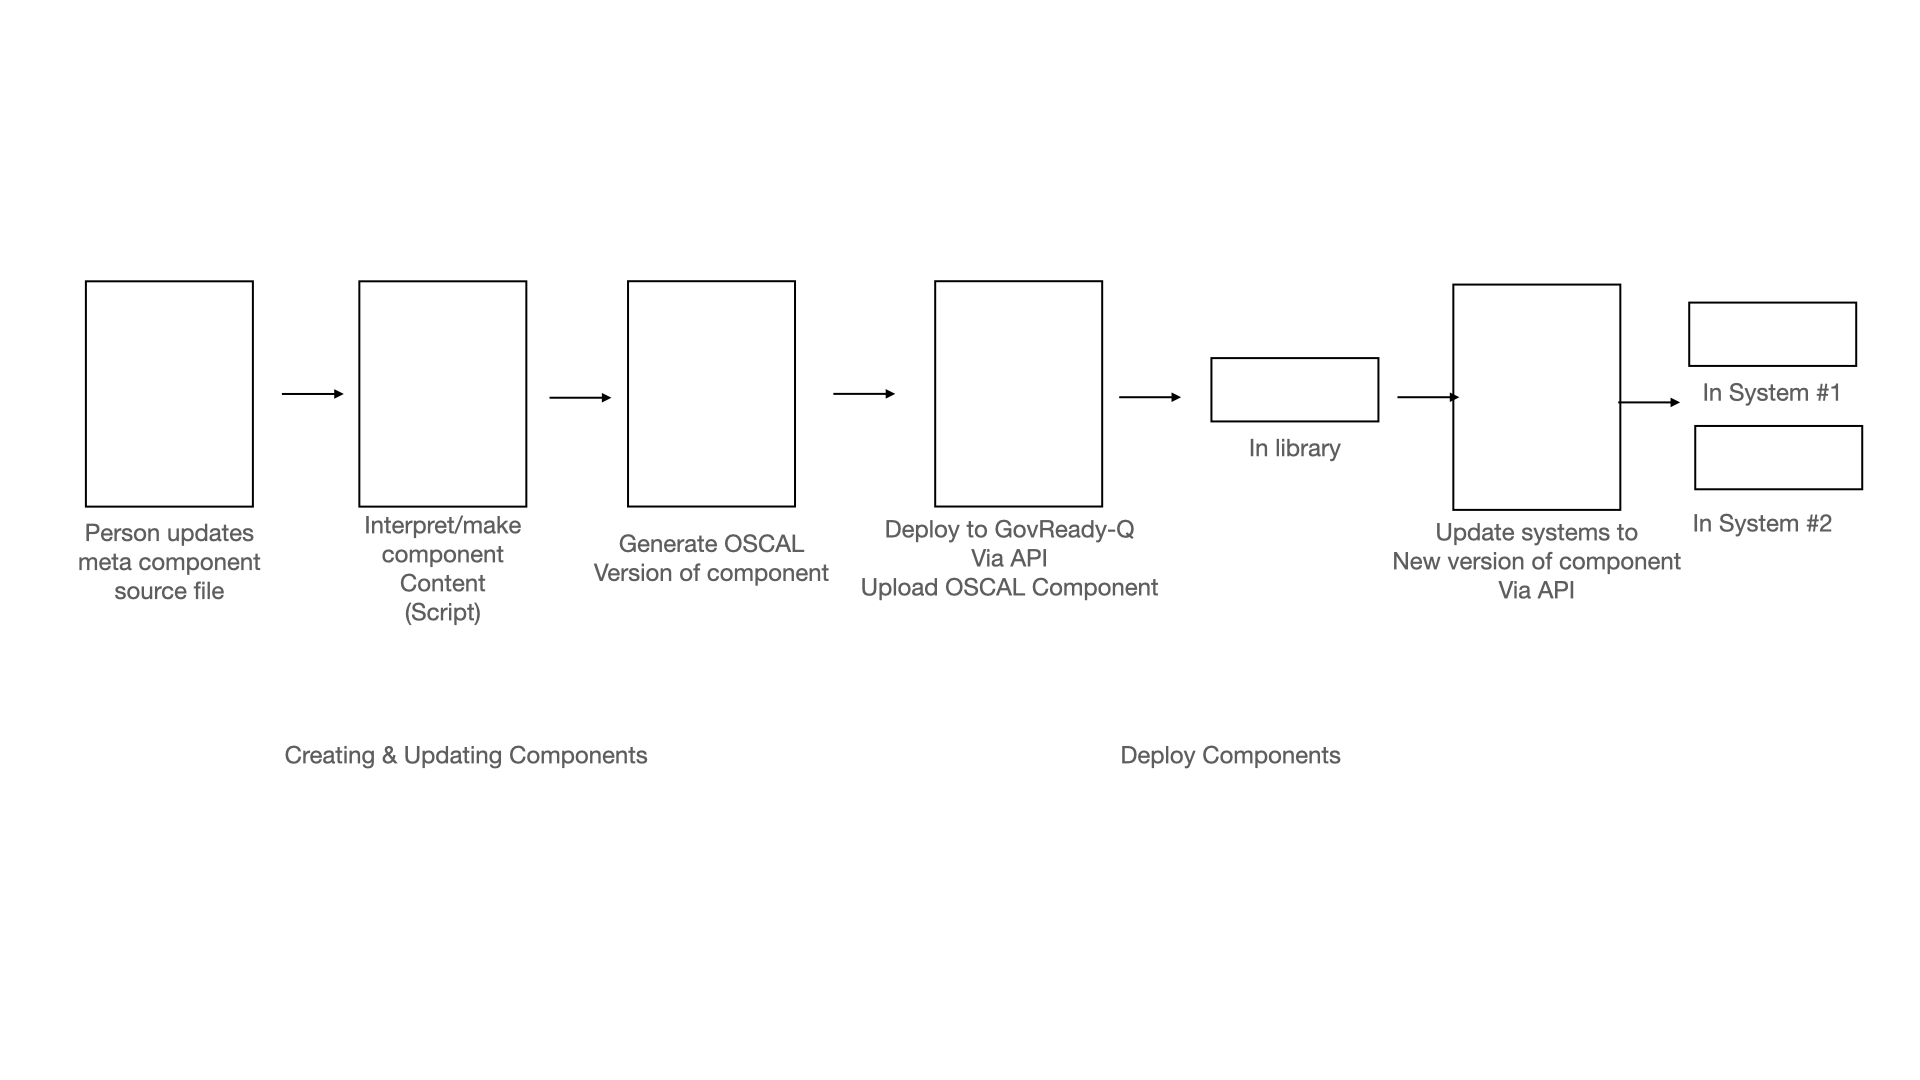


Reference code

1. ComponentHub
2. POA&M Generation


# Notes

Turning on OpenControl in GovReady-Q

Enable `enable_experimental_opencontrol` in Django Admin at 
http://example.com/admin/system_settings/systemsettings/1/change/

API Key can be found https://example.com/api-keys

# Code

## Configuration

In [ ]:
# install python packages
%pip install rtyaml
%pip install natsort

# import python packages
import rtyaml
import json
import os
import glob
import uuid
import requests
import datetime
from collections import defaultdict
from itertools import groupby
from natsort import natsorted
from dataclasses import dataclass, field

# settings
OUTPUTDIR = "output"
API_URL = "http://localhost:8000/api/v2/elements/createOSCAL/"
API_KEY = 'ui9AeETDjUWYSk9kjQ8EXxGDt0AupBAS'

## Stage 1 - Generate OpenControl files

First step of our pipeline is to generate OpenControl files. These can initially be generated in bulk from service names and then later manually updated for each service.

In [ ]:
# list services
SERVICE_NAMES = [
    'Consolidated Audit Service',
    'Email Service',
    'Consolidated Database Service',
    'Network Service',
    'Identity Management Service',
    'DevSecOps CI/CD Service',
    'Artifact Repository Service',
    'Git Repository Service'
]

In [ ]:
# Open-Control Skeleton
OC_SKELETON_YAML = """documentation_complete: false
name: Component Name
references:
- name: Reference
  path: http://VerificationURL.com
satisfies:
- control_key: cm-5
  covered_by: []
  implementation_status: implemented
  control_origin: inherited
  narrative:
    - text: "Control implementation statement for CM-5"
- control_key: cm-6
  covered_by: []
  implementation_status: partial
  control_origin: inherited
  narrative:
    - key: "a"
      text: "Control implementation statement for CM-6 part A"
    - key: "b"
      text: "Control implementation statement for CM-6 part B"
  parameters:
    - key: "a"
      text: "Parameter A for CM-6"
    - key: "b"
      text: "Parameter B for CM-6"
  standard_key: NIST_800-53_rev4
responsible_role: Role Name
schema_version: 3.0.0
verifications:
- key: EC2_Verification_2
  name: EC2 Governor 2
  path: artifact-ec2-1.png
- key: EC2_Verification_1
  name: EC2 Verification 1
  path: http://VerificationURL.com
extension:
- last-modified: 2022-10-30T19:14:13+00:00,
  version: 2022-10-30T19:14:13+00:00 
"""

OC_SKELETON = rtyaml.load(OC_SKELETON_YAML)

In [ ]:
def slugify(name):
    """Return a slugified value for name"""
    return name.replace("/","").replace(" ","_").lower()

In [ ]:
def generate_open_control_file(oc_skel, srvc_nm):
    """Return a simulated open-control object generated from service name"""
    oc_skel.update({'name': srvc_nm}) if 'name' in oc_skel else oc_skel.setdefault('name', srvc_nm)
    # TODO: Generate more content for OpenControl Component
    return oc_skel

In [ ]:
# simulate generation of Open-Control files
outputdir_oc = os.path.join(OUTPUTDIR, "opencontrol")
#ensure_dir(outputdir_oc)

for srvc_nm in SERVICE_NAMES:
    oc_obj = generate_open_control_file(OC_SKELETON, srvc_nm)
    filedir = outputdir_oc
    filename = f"{slugify(oc_obj.get('name', 'error'))}.yaml"
    filepath = os.path.join(filedir, filename)
    print(f"write OpenControl file {filepath}")
    with open(filepath, "w") as f:
        f.write(rtyaml.dump(oc_obj))

## Stage 2 - Manually maintain OpenControl for each service

The created OpenControl files are manually maintained by each team.

## Stage 3 - Convert OpenControl to OSCAL

This stage converts the existing OpenControl artifacts saved on disk to OSCAL artifacts saved on disk.

### Dataclasses to re-create relevant GovReady-Q models

In [ ]:
# define dataclasses
def get_datetime():
    return datetime.datetime.now()

def empty_list():
    return []

@dataclass
class Element:
    """Class simulating a GovReady-Q Element"""
        
    name: str
    created: datetime.datetime = datetime.datetime.now()
    updated: datetime.datetime = datetime.datetime.now()
    # created: datetime.datetime(2022, 10, 30, 19, 14, 16, 735990, tzinfo=<UTC>),
    # updated: datetime.datetime(2022, 10, 30, 19, 14, 16, 735998, tzinfo=<UTC>),
    full_name: str = ""
    description: str = ""
    element_type: str = ""
    oscal_version: str = "1.0.0"
    uuid: str = str(uuid.uuid4())
    component_type: str = 'software'
    component_state: str = 'operational'
    tags: list = field(default_factory=empty_list)

@dataclass
class Organization:
    """Class simulating a GovReady-Q Organization"""
    
    name: str = "main"
    slug: str = "main"
    
@dataclass
class Statement:
    """Class simulating a GovReady-Q Statement"""
    
    sid: str
    sid_class: str
    source: str
    pid: str
    body: str
    statement_type: str = "CONTROL_IMPLEMENTATION_PROTOTYPE"
    remarks: str = ""
    status: str = ""
    version: str = "" 
    # created = models.DateTimeField(auto_now_add=True, db_index=True)
    # updated = models.DateTimeField(auto_now=True, db_index=True)
    uuid: str = str(uuid.uuid4())

### Methods to convert OpenControl content to OSCAL content via GovReady-Q models

In [ ]:
def convert_oc_satisfies_to_smt_list(oc_satisfies):
    """Return an array of statement objects given an OpenControl satisfies list"""

    # OpenControl lists implementations statements as items in the `satisfies` list.
    smts = []
    for ctl_item in oc_satisfies:
        # print(ctl_item)
        for narr_item in ctl_item.get("narrative", []):
            smt = Statement(
                sid=ctl_item.get("control_key", None),
                sid_class=ctl_item.get("standard_key", None),
                source=ctl_item.get("source", None),
                pid=None,
                body=None,
                statement_type="CONTROL_IMPLEMENTATION_PROTOTYPE",
                remarks=None,
                status=ctl_item.get("implementation_status", None),
                #  covered_by=ctl_item.get("covered_by", []),
                #  security_control_type=ctl_item.get("security_control_type", "")  
            )
            smt.pid = narr_item.get("key", None)
            smt.body = narr_item.get("text", None)
            smts.append(smt)
    return smts

In [ ]:
# generate OSCAL statements using GovReady-Q's OSCALComponentSerializer
class ComponentSerializer(object):

    def __init__(self, element, impl_smts):
        self.element = element
        self.impl_smts = impl_smts

class OSCALComponentSerializer(ComponentSerializer):

    @staticmethod
    def statement_id_from_control(control_id, part_id):
        # Checking for a case where the control was provided like ac-2.3 which already has its part included.
        if part_id:
            if part_id not in control_id:
                return f"{control_id}.{part_id}"

        return f"{control_id}"

    def generate_source(self, src_str):
        """Return a valid catalog source given string"""
        DEFAULT_SOURCE = "NIST_SP-800-53_rev5"
        if not src_str:
            return DEFAULT_SOURCE
        # TODO: Handle other cases
        source = src_str
        return source

    def as_json(self):
        # Build OSCAL
        # Example: https://github.com/usnistgov/OSCAL/blob/master/src/content/ssp-example/json/example-component.json
        comp_uuid = str(self.element.uuid)
        control_implementations = []
        props = []
        
        # orgs
        org = Organization()
        orgs = [org]
        # orgs = list(Organization.objects.all())  # TODO: orgs need uuids, not sure which orgs to use for a component
        
        
        parties = [{"uuid": str(uuid.uuid4()), "type": "organization", "name": org.name} for org in orgs]
        responsible_roles =  [{
           "role-id": "supplier",# TODO: Not sure what this refers to
            "party-uuids": [ str(party.get("uuid")) for party in parties ]

        }]
        of = {
            "component-definition": {
                "uuid": str(uuid.uuid4()),
                "metadata": {
                    "title": "{}".format(self.element.name),
                    "last-modified": self.element.updated.replace(microsecond=0).isoformat(),
                    "version": self.element.updated.replace(microsecond=0).isoformat(),
                    "oscal-version": self.element.oscal_version,
                    "parties": parties
                },
                "components": [
                   {
                        "uuid": comp_uuid,
                        "type": self.element.component_type.lower() if self.element.component_type is not None else "software",
                        "title": self.element.full_name or self.element.name,
                        "description": self.element.description,
                        "responsible-roles": responsible_roles, # TODO: gathering party-uuids, just filling for now
                        "props": props,
                        "control-implementations": control_implementations
                    }
                ]
            },
        }

        # Add component's tags if they exist
#         if self.element.tags.exists():
#             props.extend([{"name": "tag", "ns": "https://govready.com/ns/oscal", "value": tag.label} for tag in self.element.tags.all()])

        # Remove 'metadata.props' key if no metadata.props exist
        if len(props) == 0:
            of['component-definition']['metadata'].pop('props', None)

        # create requirements and organize by source (sid_class)

        by_class = defaultdict(list)

        # work:
        # group stmts by control-id
        # emit an requirement for the control-id
        # iterate over each group
        # emit a statement for each member of the group
        # notes:
        # - OSCAL implemented_requirements and control_implementations need UUIDs
        #   which we don't have in the db, so we construct them.
        
        # print("self.impl_smts:\n", self.impl_smts)

        for control_id, group in groupby(natsorted(self.impl_smts, key=lambda ismt: ismt.sid),
                                         lambda ismt: ismt.sid):

            for smt in group:
                statement_id = self.statement_id_from_control(control_id, smt.pid)
                statement_req = {
                    "uuid": str(smt.uuid),
                    "description": smt.body,
                    "control-id": statement_id,
                }
                # key-value by sid a.k.a control id for each requirement
                if statement_req not in by_class[smt.sid]:
                    by_class[smt.sid].append(statement_req)

        for sid_class, requirements in by_class.items():
            control_implementation = {
                "uuid":str(uuid.uuid4()),# TODO: Not sure if this should implemented or just generated here.
                "source": self.generate_source(smt.source if smt.source else None),
                "description": f"This is a partial implementation of the {sid_class} catalog, focusing on the control enhancement {requirements[0].get('control-id')}.",
                "implemented-requirements": [req for req in requirements]
            }
            control_implementations.append(control_implementation)
        # Remove 'control-implementations' key if no implementations exist
        if len(control_implementations) == 0:
            of['component-definition']['components'][0].pop('control-implementations', None)

        oscal_string = json.dumps(of, sort_keys=False, indent=2)
        return oscal_string

In [ ]:
def generate_oscal_from_opencontrol(oc_obj):
    """Generate OSCAL from OpenControl object"""

    # set name
    component_name = oc_obj.get("name", "missing name")
    component = Element(name=component_name)
    component.full_name = component.name
    
    # prepare statements
    smts = convert_oc_satisfies_to_smt_list(oc_obj.get('satisfies', []))
    # generate OSCAL using OSCALComponentSerializer
    oscal_cmpt = OSCALComponentSerializer(component, smts)
    #print("oscal_cmpt.as_json\n", oscal_cmpt.as_json())
    return oscal_cmpt.as_json()

### Loop to convert each OpenControl file to OSCAL file

In [ ]:
outputdir_oc = os.path.join(OUTPUTDIR, "opencontrol")
outputdir_oscal = os.path.join(OUTPUTDIR, "oscal")
# for each open-control file, generate an OSCAL file
for file in glob.glob(os.path.join(outputdir_oc, "*.yaml")):
    # read OpenControl file
    with open(file) as f:
        oc_obj = rtyaml.load(f)

    # generate OSCAL from OpenControl
    oscal_obj = json.loads(generate_oscal_from_opencontrol(oc_obj))
    
    # determine OSCAL file name
    component_name = oc_obj.get("name", "missing name")
    filename_oscal = f"{slugify(component_name)}.json"
    filepath_oscal = os.path.join(outputdir_oscal, filename_oscal)
    # write OSCAL file
    with open(filepath_oscal, "w") as f:
        json.dump(oscal_obj, f, ensure_ascii=False, indent=4)
    
#     response_status_code, response_json = upload_cmpt_to_govready(API_KEY, oscal_obj)
#     print(response_status_code)

### Stage 4 - Deploy OSCAL components to GovReady-Q via API

In [ ]:
def upload_cmpt_to_govready(api_key, oscal_json):
    """Upload a component in OSCAL format to GovReady-Q via API"""

    # GovReady-Q API usage
    # curl --header "Authorization: {your-api-key}" \
    #  {site base URL}/api/v1/projects/{project id}/answers

    api_url = API_URL
    # print("oscal_json \n", oscal_json)
    request_json = {"oscal": oscal_json}
    headers = {'Authorization': api_key}
    response = requests.post(api_url, json=request_json, headers=headers)
    # print(response.status_code)
    # print(response.json())
    return response.status_code, response.json()

In [ ]:
# upload each OSCAL file to GovReady-Q via API
for file in glob.glob(os.path.join(OUTPUTDIR, "*.json")):
    # read OSCAL file
    with open(file, 'r') as f:
        oscal_obj = json.load(f)
    # upload OSCAL to GovReady-Q
    response_status_code, response_json = upload_cmpt_to_govready(API_KEY, oscal_obj)
    
    print(f"response: {response_status_code}")
    # print(response_json)